In [1]:
from os.path import join as j
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc
import networkx as nx
import numpy as np
import random

In [2]:
with open("../data_dirs.txt", "r") as f: # your dataset folder should  be in a text file here
    DATA_DIRS = f.readlines()
    DATA_DIRS = [p.strip() for p in DATA_DIRS]

In [3]:
POS_PATH = j(DATA_DIRS[0], "derived", "journal_citations", "link_prediction", "aps_all_2010_link_pred_50-pct_removed.csv")
NEG_PATH = j(DATA_DIRS[0], "derived", "journal_citations", "link_prediction", "aps_all_2010_link_pred_50-pct_negsamp.csv")

In [4]:
pos = pd.read_csv(POS_PATH, dtype="str")
neg = pd.read_csv(NEG_PATH, dtype="str")

In [5]:
# labels
pos["TRUE"] = 1
neg["TRUE"] = 0

# Load embeddings, calculate scores

In [6]:
EMB_PROPERTY = ["undirected"]*3 + ["title"]*3# + ["abstract"]*3
EMB_METHOD = ["leigenmap", "node2vec", "residual2vec"] + ["doc2vec", "scibert", "sentencebert"]#*2
EMB = zip(EMB_PROPERTY, EMB_METHOD)

In [7]:
fpr = {}
tpr = {}
roc_auc = {}

In [8]:
# graph, title embeddings
for e in EMB:
    EMB_PATH = j(DATA_DIRS[0], "embedding", "link-prediction", "aps_all_2010_{}_{}_50-pct_vector.gz".format(e[0], e[1]))
    embedding = pd.read_csv(EMB_PATH, index_col="DOI")
    emb_cols = [str(i) for i in range(embedding.shape[1])]
    
    test_data = pd.concat([pos.drop(["CITING_YEAR", "CITED_YEAR"], axis=1), neg])
    distance_left = test_data[["CITING_DOI"]].merge(embedding, left_on="CITING_DOI", right_index=True, how="left")
    distance_right = test_data[["CITED_DOI"]].merge(embedding, left_on="CITED_DOI", right_index=True, how="left")
    
    test_data["PRED"] = (
    np.einsum("ij,ij->i", distance_left[emb_cols].values, distance_right[emb_cols].values)
    / (
        np.linalg.norm(distance_left[emb_cols].values, axis=1)
        * np.linalg.norm(distance_right[emb_cols].values, axis=1)
    )
    )
    test_data = test_data[~pd.isna(test_data.PRED)]
    
    e_fpr, e_tpr, _ = roc_curve(test_data["TRUE"], test_data["PRED"])
    fpr[e] = e_fpr
    tpr[e] = e_tpr
    roc_auc[e] = auc(e_fpr, e_tpr)

# Abstract embedding scores

In [9]:
NETWORK_PATH = j(DATA_DIRS[0], "derived", "journal_citations", "link_prediction", "abstract_aps_all_2010_link_pred_{}-pct_neg-0.gz".format(50))
POS_PATH = j(DATA_DIRS[0], "derived", "journal_citations", "link_prediction", "abstract_aps_all_2010_link_pred_{}-pct_neg-0_pos.csv".format(50))
APS_CIT_PATH = j(DATA_DIRS[0], "derived", "journal_citations", "aps_all_2010_citations.csv")

In [10]:
pos = pd.read_csv(POS_PATH, dtype="str")
network = pd.read_csv(NETWORK_PATH, dtype="str")
aps_all = pd.read_csv(APS_CIT_PATH, dtype="str")

In [11]:
# Sample negative edges
REMOVE_EDGE_NO = len(pos)
buffer = 100000 # in case some edges already do exist, or if date is weird
sample_ref = random.sample(list(network.CITED_DOI.values), REMOVE_EDGE_NO+buffer)
sample_paper = random.sample(list(network.CITING_DOI.values), REMOVE_EDGE_NO+buffer)
neg = pd.DataFrame(data={"CITING_DOI":sample_paper, "CITED_DOI":sample_ref})

# ensure date of citing paper < date of cited reference
neg = neg.merge(aps_all[["CITING_DOI", "CITING_YEAR"]].drop_duplicates(), on="CITING_DOI")\
                     .merge(aps_all[["CITED_DOI", "CITED_YEAR"]].drop_duplicates(), on="CITED_DOI")
neg = neg[neg.CITING_YEAR >= neg.CITED_YEAR]

In [12]:
# Ensure all edges don't exist in embedded network
neg = neg.merge(network[["CITING_DOI", "CITED_DOI"]], on=["CITING_DOI", "CITED_DOI"], how="left", indicator=True)
neg = neg[neg._merge == "left_only"].drop("_merge", axis=1)
neg = neg.sample(n = REMOVE_EDGE_NO)

In [13]:
# labels
pos["TRUE"] = 1
neg["TRUE"] = 0

In [14]:
pos = pos.drop(labels=["CITING_ABSTRACT", "CITED_ABSTRACT"], axis=1)

In [15]:
neg = neg.drop(labels=["CITING_YEAR", "CITED_YEAR"], axis=1)

In [16]:
EMB_PROPERTY = ["abstract"]*3
EMB_METHOD = ["doc2vec", "scibert", "sentencebert"]
EMB = zip(EMB_PROPERTY, EMB_METHOD)

for e in EMB:
    EMB_PATH = j(DATA_DIRS[0], "embedding", "link-prediction", "aps_all_2010_{}_{}_50-pct_vector.gz".format(e[0], e[1]))
    embedding = pd.read_csv(EMB_PATH, index_col="DOI")
    emb_cols = [str(i) for i in range(embedding.shape[1])]
    
    test_data = pd.concat([pos, neg])
    distance_left = test_data[["CITING_DOI"]].merge(embedding, left_on="CITING_DOI", right_index=True, how="left")
    distance_right = test_data[["CITED_DOI"]].merge(embedding, left_on="CITED_DOI", right_index=True, how="left")
    
    test_data["PRED"] = (
    np.einsum("ij,ij->i", distance_left[emb_cols].values, distance_right[emb_cols].values)
    / (
        np.linalg.norm(distance_left[emb_cols].values, axis=1)
        * np.linalg.norm(distance_right[emb_cols].values, axis=1)
    )
    )
    test_data = test_data[~pd.isna(test_data.PRED)]
    
    e_fpr, e_tpr, _ = roc_curve(test_data["TRUE"], test_data["PRED"])
    fpr[e] = e_fpr
    tpr[e] = e_tpr
    roc_auc[e] = auc(e_fpr, e_tpr)

In [17]:
roc_auc

{('undirected', 'leigenmap'): 0.9285662845806861,
 ('undirected', 'node2vec'): 0.9886551590425251,
 ('undirected', 'residual2vec'): 0.9806462898062036,
 ('title', 'doc2vec'): 0.5475960202632849,
 ('title', 'scibert'): 0.5502424359111607,
 ('title', 'sentencebert'): 0.863142884349383,
 ('abstract', 'doc2vec'): 0.6367622453946267,
 ('abstract', 'scibert'): 0.5391735661879539,
 ('abstract', 'sentencebert'): 0.9280126247733154}

# Figure

In [18]:
labels = [
    "Laplacian Eigenmap",
    "node2vec",
    "residual2vec",
    "doc2vec, title",
    "SciBERT, title",
    "Sentence-BERT, title",
    "doc2vec, abstract",
    "SciBERT, abstract",
    "Sentence-BERT, abstract",
]
labels = dict(zip(roc_auc.keys(), labels))

In [19]:
fig_colors = ["teal", "steelblue", "blue", "orchid", "coral", "orange", "darkorchid", "tab:red", "darkorange"]
fig_colors = dict(zip(roc_auc.keys(), fig_colors))

In [20]:
fig_colors

{('undirected', 'leigenmap'): 'teal',
 ('undirected', 'node2vec'): 'steelblue',
 ('undirected', 'residual2vec'): 'blue',
 ('title', 'doc2vec'): 'orchid',
 ('title', 'scibert'): 'coral',
 ('title', 'sentencebert'): 'orange',
 ('abstract', 'doc2vec'): 'darkorchid',
 ('abstract', 'scibert'): 'tab:red',
 ('abstract', 'sentencebert'): 'darkorange'}

In [21]:
dict(sorted(roc_auc.items(), key=lambda item: item[1], reverse=True))

{('undirected', 'node2vec'): 0.9886551590425251,
 ('undirected', 'residual2vec'): 0.9806462898062036,
 ('undirected', 'leigenmap'): 0.9285662845806861,
 ('abstract', 'sentencebert'): 0.9280126247733154,
 ('title', 'sentencebert'): 0.863142884349383,
 ('abstract', 'doc2vec'): 0.6367622453946267,
 ('title', 'scibert'): 0.5502424359111607,
 ('title', 'doc2vec'): 0.5475960202632849,
 ('abstract', 'scibert'): 0.5391735661879539}

In [22]:
roc_auc = dict(sorted(roc_auc.items(), key=lambda item: item[1], reverse=True))

In [23]:
FIG_PATH = j("outputs", "aps_all_2010_link_pred_50-pct_all_abs.pdf")

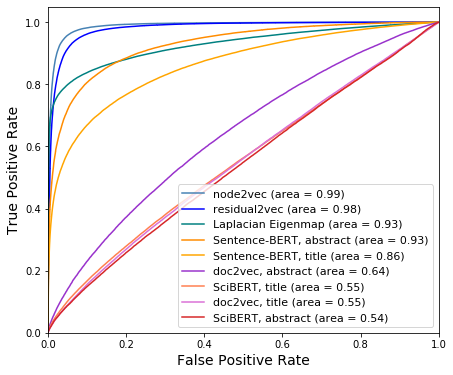

In [25]:
plt.figure(figsize=(7,6))
for e in (roc_auc.keys()):
    plt.plot(
        fpr[e],
        tpr[e],
        label= labels[e] + " (area = %0.2f)" % roc_auc[e],
        color=fig_colors[e]
    )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.savefig(FIG_PATH, bbox_inches="tight")